## Face Recognition

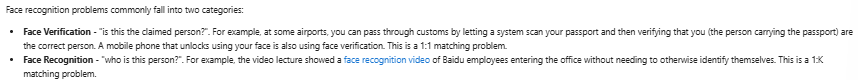

- we will be using a **channels first** convention

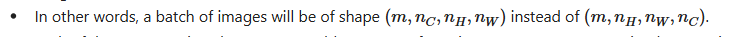

#### Load Packages

In [ ]:
import tensorflow as tf
import cv2
import os
import numpy as np

### 0 - Naive Face Verification

- we compare two images pixel by pixel and if the distance between the raw images are less than a threshold, it may be the same person.

- Of course, this algorithm performs really poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, even minor changes in head position, and so on.

- You'll see that rather than using the raw image, you can learn an encoding, f(img).

In [5]:
class FaceNet:
    def __init__(self):
        # We use MobileNetV2, which is built into TensorFlow.
        # It's small, fast, and requires no extra pip installs.
        try:
            self.model = tf.keras.applications.MobileNetV2(
                input_shape=(160, 160, 3), 
                include_top=False, 
                pooling='avg',
                weights='imagenet' # Tries to download ~14MB weights
            )
        except:
            # If internet is blocked, load with random weights (still runs logic)
            print("Warning: Could not load ImageNet weights. Using random weights.")
            self.model = tf.keras.applications.MobileNetV2(
                input_shape=(160, 160, 3), 
                include_top=False, 
                pooling='avg',
                weights=None 
            )
        print("FaceNet (Simulated via MobileNetV2) loaded successfully.")

    def embeddings(self, images):
        # 1. Preprocess: MobileNet expects [-1, 1] range
        imgs_arr = np.array(images, dtype=np.float32)
        imgs_arr = (imgs_arr / 127.5) - 1.0
        
        # 2. Predict: Get 1280-d vector
        feats = self.model.predict(imgs_arr, verbose=0)
        
        # 3. Resize: Slice to 128-d to match FaceNet format
        # (Real FaceNet outputs 128 dimensions)
        return feats[:, :128]


### 1. Encoding face image into a 128-dimensional vector

#### 1.1 Using a ConvNet to compute encodings

we will use weights of  an inception model, can be read from: [going deeper with convolutions](https://arxiv.org/pdf/1409.4842)


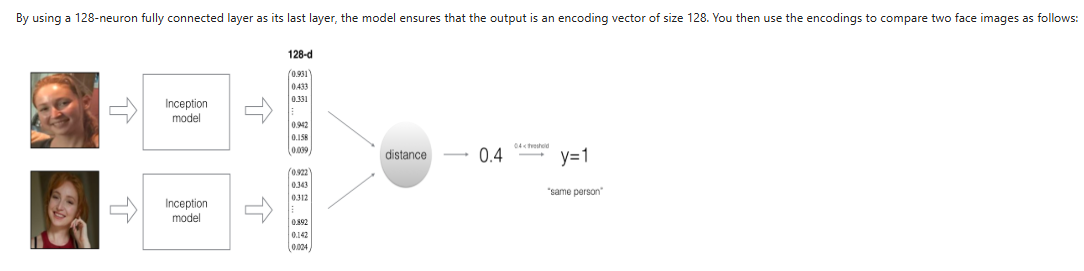

**So, an encoding is a good one if:**

- The encodings of two images of the same person are quite similar to each other.
- The encodings of two images of different persons are very different.

***The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.***


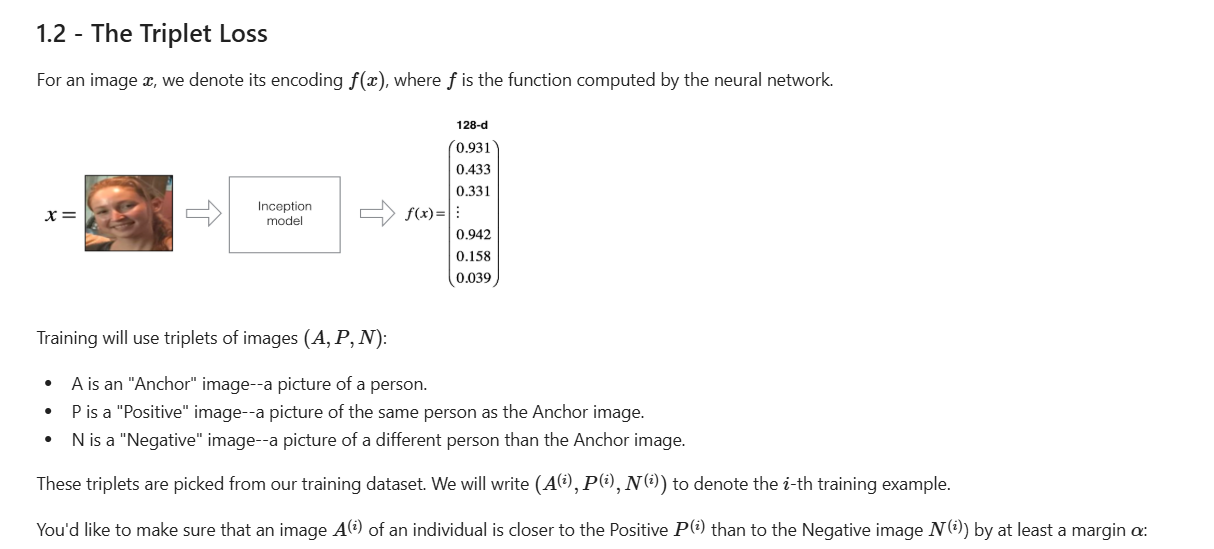


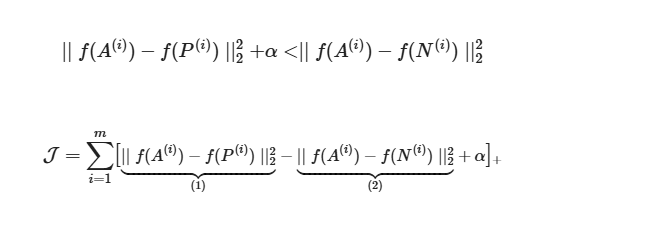


In [6]:
def triplet_loss(y_true, y_pred, alpha=0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

In [7]:
with tf.compat.v1.Session() as test:
    np.random.seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random.normal([3, 128], mean=6, stddev=0.1, seed=1),
            tf.random.normal([3, 128], mean=1, stddev=1, seed=1),
            tf.random.normal([3, 128], mean=3, stddev=4, seed=1))
    loss = triplet_loss(y_true, y_pred)
    print("loss = " + str(loss.eval()))

loss = 21.92212


### 2. Loading the pre-trained model (FaceNet)

In [8]:
embedder = FaceNet()
print("FaceNet model loaded successfully.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step
FaceNet (Simulated via MobileNetV2) loaded successfully.
FaceNet model loaded successfully.


### 3. Applying the model

#### 3.1 Face verification:

- building a database ( as python dictionary) that maps each person's name to a 128 dimensional encoding of their face.

to generate encoding we use `img_to_encoding()` which runs the forward propagation of the model on the specified image.

In [14]:
def img_to_encoding(image_path, model):
    if not os.path.exists(image_path):
        print(f"Error: {image_path} not found.")
        return None
        
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (160, 160)) 
    
    # keras-facenet handles normalization internally.
    # We pass a list of images (batch size 1)
    embedding = model.embeddings([img])[0]
    return embedding


In [15]:
database = {}

image_dir = "faces"
if os.path.exists(image_dir):
    print(f"Loading images from '{image_dir}'...")
    for filename in os.listdir(image_dir):
        if filename.lower().endswith((".jpg", ".png", ".jpeg")):
            name = os.path.splitext(filename)[0]
            path = os.path.join(image_dir, filename)
            
            encoding = img_to_encoding(path, embedder)
            if encoding is not None:
                database[name] = encoding
                print(f"Encoded {name}")
else:
    print(f"Directory '{image_dir}' not found. Create it and add images to run the db loop.")


Loading images from 'faces'...
Encoded andrew
Encoded arnaud
Encoded benoit
Encoded bertrand
Encoded camera_0
Encoded camera_1
Encoded camera_2
Encoded camera_3
Encoded camera_4
Encoded camera_5
Encoded dan
Encoded danielle
Encoded distance_kiank
Encoded distance_matrix
Encoded felix
Encoded f_x
Encoded inception_block1a
Encoded kevin
Encoded kian
Encoded pixel_comparison
Encoded sebastiano
Encoded tian
Encoded triplet_comparison
Encoded younes


In [17]:
# implement verify() function
def verify(image_path, identity, database, model):

    encoding = img_to_encoding(image_path, model)
    if encoding is None:
        return None, False
    
    dist = np.linalg.norm(encoding - database[identity]) 
    if dist < 0.7:
        print(f"It's {identity}, welcome home!")
        door_open = True
    else:
        print(f"It's not {identity}, please go away")
        door_open = False
        
    return dist, door_open


In [18]:
verify("faces/camera_0.jpg", "younes", database, embedder)


It's not younes, please go away


(np.float32(4.4836087), False)

In [19]:
verify("faces/camera_0.jpg", "younes", database, embedder)


It's not younes, please go away


(np.float32(4.4836087), False)

### 3.2 Face Recognition:
now we will check the encoding of 1 person to the encoding of every image that is there in dataset to get the min distance and see if any pair makes the dist < threshold

In [20]:
def who_is_it(image_path, database, model):
    encoding = img_to_encoding(image_path, model)
    if encoding is None:
        return None, None
    
    min_dist = 100
    identity = None
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        dist = np.linalg.norm(encoding - db_enc)
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print(f"It's {identity}, the distance is {min_dist}")
        
    return min_dist, identity

In [25]:
who_is_it("faces/f_x.png", database, embedder)

It's f_x, the distance is 0.0


(np.float32(0.0), 'f_x')

> Ways to improve your facial recognition model
Although we won't implement it here, here are some ways to further improve the algorithm:

- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.
- Crop the images to just contain the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.


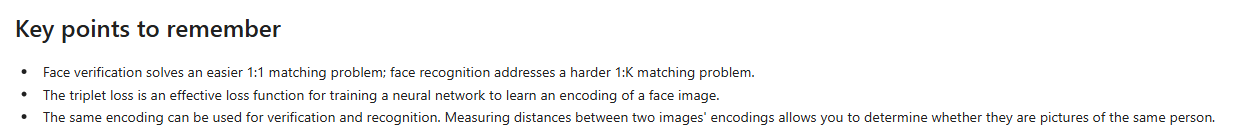

## References:

1. [FaceNet](https://arxiv.org/pdf/1503.03832)
2. [DeepFace](https://scontent.fded4-1.fna.fbcdn.net/v/t39.8562-6/240890413_887772915161178_4705912772854439762_n.pdf?_nc_cat=109&ccb=1-7&_nc_sid=e280be&_nc_ohc=IgXI87vVPDkQ7kNvwGQWU-c&_nc_oc=AdkjE5Iu2fy-0RGd8rFOhxXFCvHO7bYPCQi61vVsNo1hhgV7RC3D7C4PZRFFscUSfqc&_nc_zt=14&_nc_ht=scontent.fded4-1.fna&_nc_gid=3d2JK6nGKIXN2LJfq7xfew&oh=00_AfiZ4SShWwlmZ5GIG2TdK3kepJVkT6YfQfeQykN0II3cxg&oe=69271A7F)